<a href="https://colab.research.google.com/github/abhiyantaabhishek/test/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Test_data.zip

In [12]:
!ls Test_data/

Test  Train  Val


In [11]:
!mv Test_data/Sample_Submission.csv Sample_Submission.csv

In [ ]:
drive.flush_and_unmount()

In [115]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ( EarlyStopping, ModelCheckpoint,ReduceLROnPlateau)
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf

In [5]:
classess = os.listdir("Test_data/Train/")
classess

['animal', 'airplane', 'truck', 'car', 'human']

In [23]:
for class_ in classess:
  img_path = os.path.join("Test_data/Train/",class_)
  print( "No of Img Train:", len(os.listdir(img_path)),',',class_)

No of Img Train: 194 , animal
No of Img Train: 194 , airplane
No of Img Train: 194 , truck
No of Img Train: 194 , car
No of Img Train: 194 , human


In [24]:
for class_ in classess:
  img_path = os.path.join("Test_data/Val/",class_)
  print( "No of Img Val:", len(os.listdir(img_path)),',',class_)

No of Img Val: 582 , animal
No of Img Val: 582 , airplane
No of Img Val: 582 , truck
No of Img Val: 582 , car
No of Img Val: 582 , human


In [ ]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

for root, dirs, files in os.walk("Test_data"):
   for name in files:
      full_path = os.path.join(root, name)
      data_type = full_path.split(os.sep)[1]
      img = plt.imread(full_path)
      if(data_type == "Train"):
        label = full_path.split(os.sep)[2]
        train_images.append(img)
        train_labels.append(label)
      elif ( data_type == "Val"):
        label = full_path.split(os.sep)[2]
        val_images.append(img)
        val_labels.append(label)
      else:
        test_images.append(img)

In [46]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
lb = LabelBinarizer()
lb.fit(train_labels)
print(lb.classes_)
train_label_onehot = lb.transform(train_labels)
val_label_onehot = lb.transform(val_labels)

['airplane' 'animal' 'car' 'human' 'truck']


In [20]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)

(970, 96, 96)
(2910, 96, 96)
(1940, 96, 96)


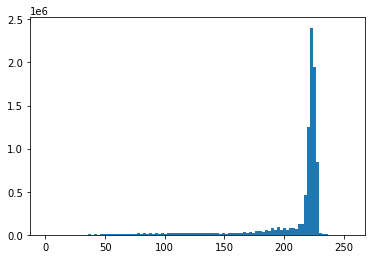

In [29]:
hist = plt.hist(train_images.flatten(),bins=100)

In [33]:
train_images_normalised = (train_images-train_images.mean())/train_images.std()
val_images_normalised = (val_images-val_images.mean())/val_images.std()

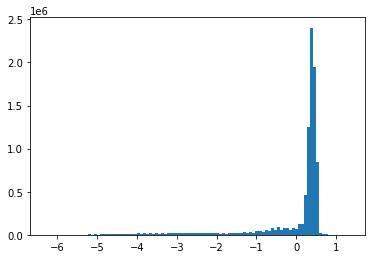

In [31]:
hist = plt.hist(train_images_normalised.flatten(),bins=100)

In [102]:
Augmented_training = ImageDataGenerator(rotation_range=90,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1)

In [51]:
K.clear_session()

In [107]:
checkpoint = ModelCheckpoint("model_{epoch:02d}",monitor='val_loss',verbose=1,save_best_only=True)
adaptiveLearningRate = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,verbose=1,min_delta=0.0001)
earlyStopping = EarlyStopping(monitor='loss',mode='auto',verbose=1,patience=25)
callback_list = [checkpoint,adaptiveLearningRate,earlyStopping]

In [98]:

def get_model(input_shape,num_of_class,hidden_size=64,dropout=0.5):
  input = tf.keras.Input(shape=(96,96,1))
  x = L.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1))(input)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x = L.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1))(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x = L.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1))(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x = L.Flatten()(x)
  x = L.Dense(hidden_size)(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.Dropout(dropout)(x)
  x = L.Dense(num_of_class,activation="softmax")(x)
  model = tf.keras.Model(input,x)
  return model

In [99]:
input_shape = (96,96,1)
num_of_class = len(lb.classes_)
model=get_model(input_shape,num_of_class)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_34 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
activation_34 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 45, 45, 64)        256

In [113]:
len(np.expand_dims(train_images_normalised,3))//64*50

750

In [ ]:

BATCH_SIZE = 32
EPOCHS = 50
model.fit(
    Augmented_training.flow(np.expand_dims(train_images_normalised,3),train_label_onehot,batch_size=BATCH_SIZE),
    steps_per_epoch = len(np.expand_dims(train_images_normalised,3))//BATCH_SIZE,
    validation_data = (val_images_normalised,val_label_onehot),
    validation_steps=len(val_images_normalised)//BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = callback_list
)

In [114]:
BATCH_SIZE = 32
EPOCHS = 50
model.fit(
    Augmented_training.flow(np.expand_dims(val_images_normalised,3),val_label_onehot,batch_size=BATCH_SIZE),
    steps_per_epoch = len(np.expand_dims(val_images_normalised,3))//BATCH_SIZE,
    validation_data = (train_images_normalised,train_label_onehot),
    validation_steps=len(train_images_normalised)//BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = callback_list
)

Epoch 1/50
90/90 [==============================] - 5s 55ms/step - loss: 2.7319 - categorical_accuracy: 0.3224 - val_loss: 1.2302 - val_categorical_accuracy: 0.4928

Epoch 00001: val_loss improved from 1.69153 to 1.23018, saving model to model_01
INFO:tensorflow:Assets written to: model_01/assets
Epoch 2/50
90/90 [==============================] - 5s 51ms/step - loss: 1.7306 - categorical_accuracy: 0.4329 - val_loss: 1.6410 - val_categorical_accuracy: 0.4021

Epoch 00002: val_loss did not improve from 1.23018
Epoch 3/50
90/90 [==============================] - 4s 50ms/step - loss: 1.4075 - categorical_accuracy: 0.4937 - val_loss: 1.6091 - val_categorical_accuracy: 0.5165

Epoch 00003: val_loss did not improve from 1.23018
Epoch 4/50
90/90 [==============================] - 4s 49ms/step - loss: 1.2789 - categorical_accuracy: 0.5181 - val_loss: 1.4544 - val_categorical_accuracy: 0.5742

Epoch 00004: val_loss did not improve from 1.23018
Epoch 5/50
90/90 [==============================] -

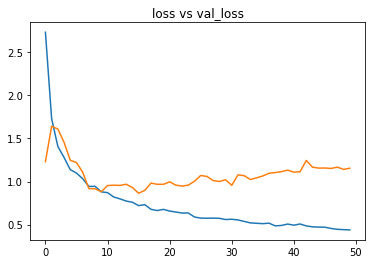

In [117]:
fig=plt.figure()
plt.plot(model.history.history["loss"],label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.title("loss vs val_loss")
plt.show()

In [121]:
prediction = model.predict(train_images_normalised)
print(classification_report(train_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93       194
      animal       1.00      0.11      0.20       194
         car       0.84      0.37      0.51       194
       human       0.62      1.00      0.77       194
       truck       0.54      0.98      0.70       194

    accuracy                           0.68       970
   macro avg       0.78      0.68      0.62       970
weighted avg       0.78      0.68      0.62       970



In [122]:
prediction = model.predict(val_images_normalised)
print(classification_report(val_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94       582
      animal       0.99      0.82      0.90       582
         car       0.99      0.83      0.90       582
       human       0.82      0.99      0.90       582
       truck       0.85      0.97      0.91       582

    accuracy                           0.91      2910
   macro avg       0.92      0.91      0.91      2910
weighted avg       0.92      0.91      0.91      2910

